In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from utils import preprocess, transform_features, handle_missing_values, standardize
from sklearn.svm import OneClassSVM

In [4]:
# XMatch case
#df_all = pd.read_csv('data/CSC2.0-GAIA_DR2_Xmatch.txt', delimiter='\t', comment='#', header=None)

# df_all.columns = [
#     'csc2_ensemble_no', 'csc2_name', 'csc2_type', 'csc2_ra', 'csc2_dec',
#     'csc2_semi_major_axis', 'csc2_semi_minor_axis', 'csc2_position_angle',
#     'csc2_semi_major_axis_psf', 'csc2_semi_minor_axis_psf', 'csc2_position_angle_psf',
#     'gaia_dr2_name', 'gaia_dr2_type', 'gaia_dr2_ra', 'gaia_dr2_dec',
#     'gaia_dr2_semi_major_axis', 'gaia_dr2_semi_minor_axis', 'gaia_dr2_position_angle',
#     'gaia_dr2_semi_major_axis_psf', 'gaia_dr2_semi_minor_axis_psf', 'gaia_dr2_position_angle_psf',
#     'match_class', 'bf_type', 'match_probability', 'separation', 'separation_sigma'
# ]

df_csc_gaia_15_all = pd.read_csv('data/allcsc_gaia_15.csv')
df_csc_all = pd.read_csv('data/allcsc_gaia_15.csv')
df_xmatch_all = pd.read_csv('data/gaia_chandra_with_features-result.csv')
#df_bad = df_all.query("match_probability < 0.7 and separation > 2 and parallax == parallax and parallax >= 0")

/tmp/ipykernel_949327/4268460441.py:14: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csc_gaia_15_all = pd.read_csv('data/allcsc_gaia_15.csv')
/tmp/ipykernel_949327/4268460441.py:15: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csc_all = pd.read_csv('data/allcsc_gaia_15.csv')


In [5]:
df_good = df_xmatch_all.query("match_probability >= 0.95 and separation < 0.2 and parallax == parallax and parallax >= 0")
df_good = df_good.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')

# Get counts of each 'Source'
source_counts = df_csc_all['Source'].value_counts()

# Identify 'Source' values that appear only once
unique_sources = source_counts[source_counts == 1].index

df_bad = df_csc_all[df_csc_all['Source'].isin(unique_sources)]

# Select entries with angDist >= 5
df_bad = df_bad.query('angDist >= 12')

# Remove entries found in df_xmatch_all
df_bad = df_bad[~df_bad['Source'].isin(df_xmatch_all['source_id'])]

# Sample to match the size of df_good
df_bad = df_bad.sample(df_good.shape[0])

df_bad['G_flux'] = df_bad['FG']
df_good['G_flux'] = df_good['phot_g_mean_flux']

In [9]:
df_bad.shape

(7907, 167)

In [11]:
df_bad['phot_g_mean_mag'] = df_bad['Gmag']
df_bad['phot_bp_mean_mag'] = df_bad['BPmag']
df_bad['phot_rp_mean_mag'] = df_bad['RPmag']
df_bad['bp_rp'] = df_bad['BP-RP']
df_bad['bp_g'] = df_bad['BP-G']
df_bad['g_rp'] = df_bad['G-RP']
df_bad['parallax'] = df_bad['Plx']
df_bad['parallax_over_error'] = df_bad['RPlx']
df_bad['sep_test'] = df_bad['angDist']
df_bad['gmag_logflux'] = df_bad['phot_g_mean_mag'] + np.log10( 1 + df_bad['flux_aper_b'])

df_good['sep_test'] = df_good['separation']
df_good['gmag_logflux'] = df_good['phot_g_mean_mag'] + np.log10( 1 + df_good['flux_aper_b'])

In [12]:
df_all = pd.concat([df_good, df_bad], ignore_index=True)

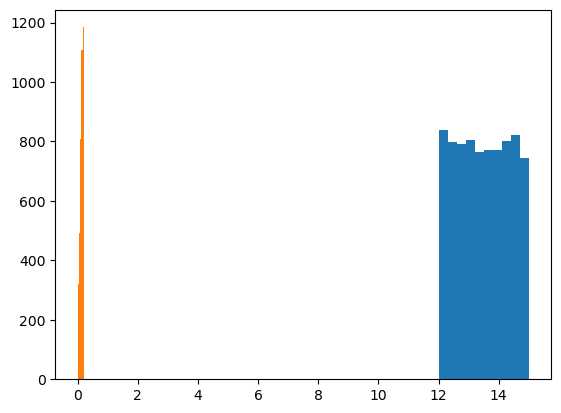

In [13]:
plt.hist(df_bad.sep_test);
plt.hist(df_good.sep_test);

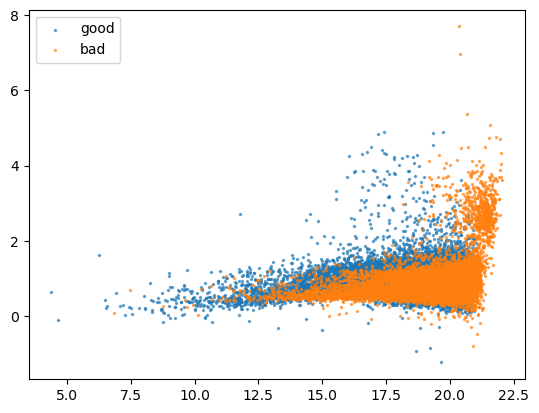

In [14]:
plt.scatter(df_good['gmag_logflux'],df_good['g_rp'],alpha=0.6, label='good', s=2)
plt.scatter(df_bad['gmag_logflux'],df_bad['g_rp'],alpha=0.6, label='bad', s=2)
plt.legend()

In [15]:
feature_names = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'flux_aper_b',
    'gmag_logflux'
]

# List of features to skip for the log transformation
skip_log_features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'gmag_logflux'
]

In [16]:
# Preprocess the data
X, Y = preprocess(df_good, df_bad, feature_names, skip_log_features)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, shuffle=True)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
X_train, X_test, scaler = standardize(X_train, X_test)

/mnt/d/workspace/starsml/utils.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [24]:
from sklearn.ensemble import IsolationForest

# Fit the model only on the positive class (i.e., Y_train == 1)
X_train_pos = X_train[Y_train == 1]

# Model Building
clf_if = IsolationForest(n_estimators=200, max_samples= 100, bootstrap=True, contamination=0.0001)
clf_if.fit(X_train_pos)

# Predictions
y_pred_if = clf_if.predict(X_test)
y_pred_if[y_pred_if == -1] = 0  # Convert -1 to 0 for binary classification

# Evaluation
print("Isolation Forest")
print("Accuracy:", accuracy_score(Y_test, y_pred_if))
print("Precision:", precision_score(Y_test, y_pred_if))
print("Recall:", recall_score(Y_test, y_pred_if))
print("F1 Score:", f1_score(Y_test, y_pred_if))

Isolation Forest
Accuracy: 0.4948366701791359
Precision: 0.49504532995994094
Recall: 0.9991489361702127
F1 Score: 0.6620611870858593


In [21]:
from sklearn.svm import OneClassSVM

# Model Building
clf_svm = OneClassSVM()
clf_svm.fit(X_train_pos)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm[y_pred_svm == -1] = 0

# Evaluation
print("One-Class SVM")
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))


One-Class SVM
Accuracy: 0.5371970495258166
Precision: 0.5350957155879672
Recall: 0.49957446808510636
F1 Score: 0.516725352112676


In [22]:
from sklearn.neighbors import LocalOutlierFactor

# Model Building
clf_lof = LocalOutlierFactor(novelty=True)
clf_lof.fit(X_train_pos)

# Predictions
y_pred_lof = clf_lof.predict(X_test)
y_pred_lof[y_pred_lof == -1] = 0

# Evaluation
print("Local Outlier Factor")
print("Accuracy:", accuracy_score(Y_test, y_pred_lof))
print("Precision:", precision_score(Y_test, y_pred_lof))
print("Recall:", recall_score(Y_test, y_pred_lof))
print("F1 Score:", f1_score(Y_test, y_pred_lof))


Local Outlier Factor
Accuracy: 0.539304531085353
Precision: 0.5183774092335276
Recall: 0.9842553191489362
F1 Score: 0.6790957134468585


In [109]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(10, activation="relu"),
      layers.Dense(5, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(10, activation="relu"),
      layers.Dense(15, activation="sigmoid")])  # Adjusted to 15 features

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()



In [110]:
autoencoder.compile(optimizer='adam', loss='mae')

In [111]:
history = autoencoder.fit(X_train_pos, X_train_pos, 
          epochs=100, 
          batch_size=512,
          validation_data=(X_test, X_test),
          shuffle=True, verbose=2)


Epoch 1/100
11/11 - 2s - loss: 4.9863 - val_loss: 4.9829 - 2s/epoch - 140ms/step
Epoch 2/100
11/11 - 0s - loss: 4.9615 - val_loss: 4.9590 - 252ms/epoch - 23ms/step
Epoch 3/100
11/11 - 0s - loss: 4.9382 - val_loss: 4.9366 - 274ms/epoch - 25ms/step
Epoch 4/100
11/11 - 0s - loss: 4.9159 - val_loss: 4.9139 - 280ms/epoch - 25ms/step
Epoch 5/100
11/11 - 0s - loss: 4.8926 - val_loss: 4.8899 - 274ms/epoch - 25ms/step
Epoch 6/100
11/11 - 0s - loss: 4.8676 - val_loss: 4.8635 - 250ms/epoch - 23ms/step
Epoch 7/100
11/11 - 0s - loss: 4.8400 - val_loss: 4.8346 - 253ms/epoch - 23ms/step
Epoch 8/100
11/11 - 0s - loss: 4.8101 - val_loss: 4.8059 - 203ms/epoch - 18ms/step
Epoch 9/100
11/11 - 0s - loss: 4.7843 - val_loss: 4.7870 - 268ms/epoch - 24ms/step
Epoch 10/100
11/11 - 0s - loss: 4.7696 - val_loss: 4.7776 - 215ms/epoch - 20ms/step
Epoch 11/100
11/11 - 0s - loss: 4.7601 - val_loss: 4.7662 - 270ms/epoch - 25ms/step
Epoch 12/100
11/11 - 0s - loss: 4.7435 - val_loss: 4.7441 - 279ms/epoch - 25ms/step
Epo

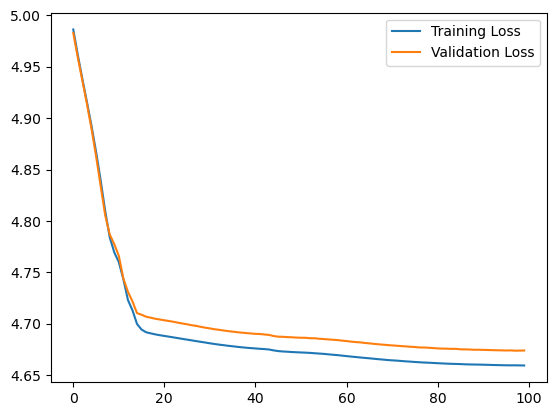

In [112]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


173/173 [==============================] - 2s 13ms/step


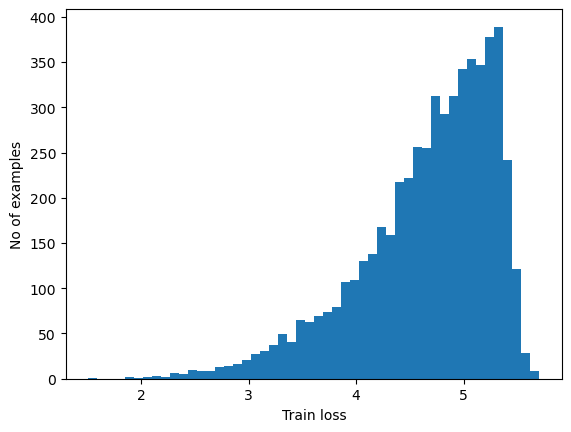

In [130]:
reconstructions = autoencoder.predict(X_train_pos)
train_loss = tf.keras.losses.mae(reconstructions, X_train_pos)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [139]:
X_train_pos

array([[1.82909430e+01, 1.86511780e+01, 1.71502150e+01, ...,
        1.00000000e+00, 4.82163733e-16, 1.82909430e+01],
       [2.03674160e+01, 2.05792260e+01, 1.98644030e+01, ...,
        2.89316517e-01, 1.64899997e-14, 2.03674160e+01],
       [1.68682540e+01, 1.54284170e+01, 1.44239940e+01, ...,
        1.00000000e+00, 1.54292395e-15, 1.68682540e+01],
       ...,
       [1.80451890e+01, 1.92932590e+01, 1.68620190e+01, ...,
        8.86261891e-01, 3.85730987e-16, 1.80451890e+01],
       [1.55944180e+01, 1.63524110e+01, 1.44788680e+01, ...,
        8.86261891e-01, 2.02508768e-15, 1.55944180e+01],
       [1.92052750e+01, 2.11115950e+01, 1.78292960e+01, ...,
        8.69836033e-01, 1.15719296e-15, 1.92052750e+01]])

In [140]:
reconstructions

array([[1.0000000e+00, 9.9998730e-01, 9.9999791e-01, ..., 8.8988763e-01,
        8.3633377e-06, 1.0000000e+00],
       [1.0000000e+00, 9.9999356e-01, 9.9999976e-01, ..., 8.8314259e-01,
        1.7126340e-06, 1.0000000e+00],
       [9.9999940e-01, 9.9993151e-01, 9.9992931e-01, ..., 8.8239676e-01,
        1.3156151e-04, 9.9999976e-01],
       ...,
       [1.0000000e+00, 9.9998581e-01, 9.9999678e-01, ..., 8.9181966e-01,
        1.1311871e-05, 1.0000000e+00],
       [9.9999940e-01, 9.9994379e-01, 9.9993044e-01, ..., 8.8864738e-01,
        1.2334187e-04, 9.9999982e-01],
       [1.0000000e+00, 9.9999654e-01, 9.9999928e-01, ..., 9.1435087e-01,
        2.9652192e-06, 1.0000000e+00]], dtype=float32)

In [127]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  5.293209063920316


12/12 [==============================] - 0s 23ms/step


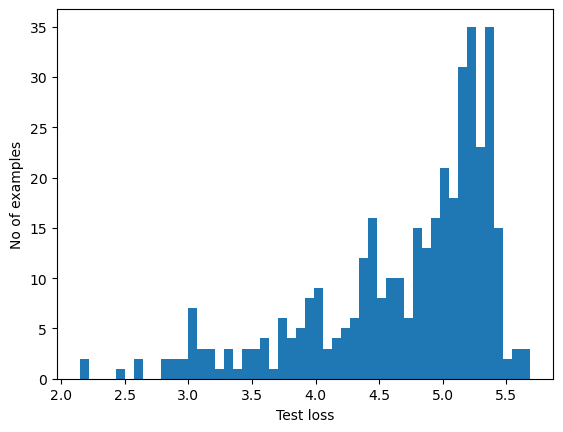

In [125]:
reconstructions = autoencoder.predict(X_test[Y_test == 0])
test_loss = tf.keras.losses.mae(reconstructions, X_test[Y_test == 0])

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [117]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))


In [128]:
preds = predict(autoencoder, X_test, threshold)
print_stats(preds, Y_test)


Accuracy = 0.7716049382716049
Precision = 0.8675664276676508
Recall = 0.8672006745362564


In [ ]:
# Predictions
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test[X_test == 1] - X_test_pred, 2), axis=1)

# Set a threshold (this needs to be fine-tuned)
threshold = np.quantile(mse, 0.55)

# Binary classification
y_pred_auto = [1 if e < threshold else 0 for e in mse]

# Evaluation
print("Autoencoder")
print("Accuracy:", accuracy_score(Y_test, y_pred_auto))
print("Precision:", precision_score(Y_test, y_pred_auto))
print("Recall:", recall_score(Y_test, y_pred_auto))
print("F1 Score:", f1_score(Y_test, y_pred_auto))

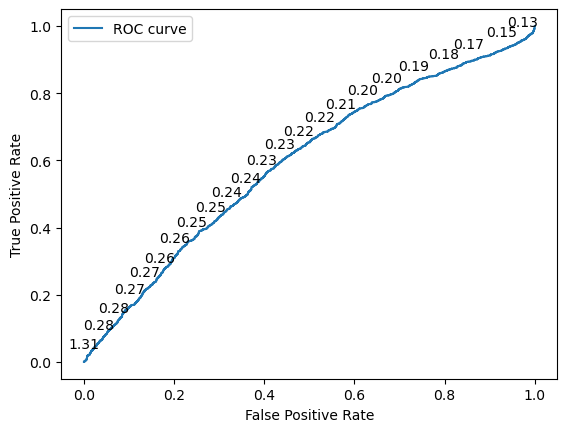

In [15]:
# Assuming Y_test and y_pred_rf_prob are defined
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_rf_prob, pos_label=1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Annotate some points on the curve. You might want to annotate just a subset
# for clarity, depending on how many points you have.
for i, threshold in enumerate(thresholds):
    if i % 100 == 0:  # annotate every 10th point
        plt.annotate(f"{threshold:.2f}", (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend(loc='best')
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 1, 2, 3], 
    'max_features': [2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, 
                           cv=10, n_jobs=-1, verbose=1, scoring='f1')

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Fitting 10 folds for each of 36 candidates, totalling 360 fits


Best parameters: {'max_depth': 3, 'max_features': 2, 'n_estimators': 50}


In [20]:
from sklearn.model_selection import cross_validate
best_params = {'max_depth': 3, 'max_features': 2, 'n_estimators': 50}

clf_rf_best = RandomForestClassifier(**best_params)
#clf_rf = RandomForestClassifier(**best_params)

#cv_scores = cross_validate(clf_rf_best, X_train, Y_train, cv=3, scoring=['f1', 'accuracy', 'recall', 'precision'],  return_train_score=True)

clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC


In [ ]:
print(f"RF train accuracy: {cv_scores['train_accuracy'].mean():.3f}")
print("Accuracy:", cv_scores['test_accuracy'].mean())
print("Precision:", cv_scores['test_precision'].mean())
print("Recall:", cv_scores['test_recall'].mean())
print("F1 Score:", cv_scores['test_f1'].mean())

In [25]:
cm = confusion_matrix(Y_test, y_pred_if, normalize='true')
print(cm)

[[0.63476071 0.36523929]
 [0.47735929 0.52264071]]


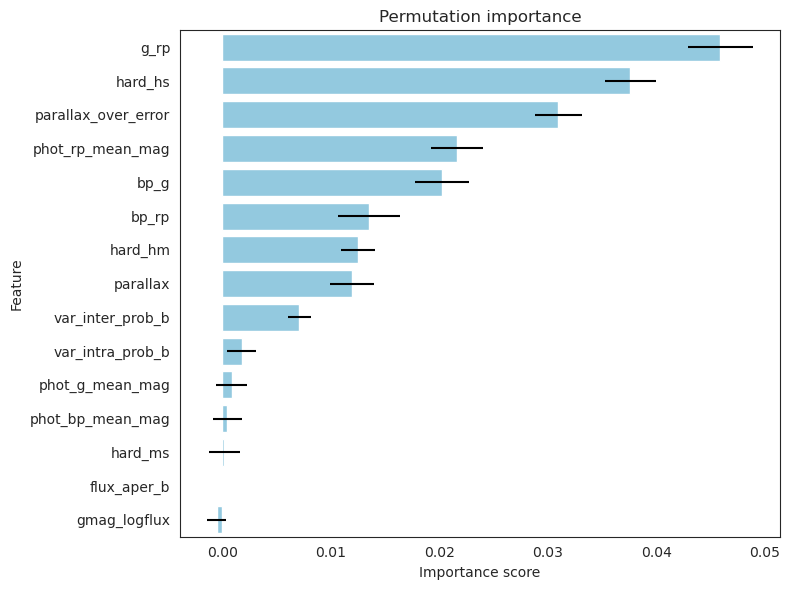

In [137]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()

/tmp/ipykernel_511834/3255613941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = y_pred_rf
/tmp/ipykernel_511834/3255613941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['actual'] = Y_test
/tmp/ipykernel_511834/3255613941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

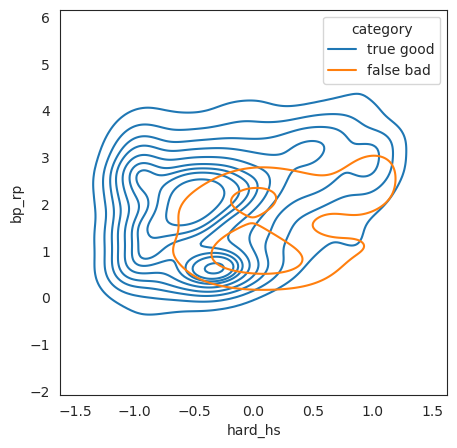

In [52]:
# Concatenate good and bad datasets to refer back later
df_test = df_all.iloc[indices_test]

# Add predictions and actual labels
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

#df_test = df_test.query('separation <=0.2 and parallax >=0')
# Define categories based on predictions and actual labels
# df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
#                                                   'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false good' if row['prediction'] == 1 else 'false bad', axis=1)

df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
                                                  'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

# Plot
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")


sns.kdeplot(data = df_test, x='hard_hs', y='bp_rp', 
            hue='category')

plt.show()


In [167]:
#df_to_test = df_csc_all[~df_csc_all['Source'].isin(df_xmatch_all['source_id'])]
df_to_test = df_xmatch_all[~df_xmatch_all['source_id'].isin(df_bad['Source'])]
df_to_test = df_to_test[~df_to_test['source_id'].isin(df_good['Source'])]
df_to_test = df_to_test.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')
#df_to_test = df_to_test.query('angDist > 5')
#df_to_test['G_flux'] = df_to_test['FG']
df_to_test['gmag_logflux'] = df_to_test['phot_g_mean_mag'] + np.log10( 1 + df_to_test['flux_aper_b'])
df_to_test['sep_test'] = df_to_test['separation']


new_df_bad_to_test = transform_features(df_to_test, feature_names, skip_log_features)
new_df_bad_to_test = imp_mean.transform(new_df_bad_to_test)
#new_df_bad_to_test = scaler.transform(new_df_bad_to_test)
y_pred_totest = clf_rf.predict_proba(new_df_bad_to_test)[:, 1]  # for AUC

/mnt/d/workspace/starsml/utils.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [168]:
df_good.shape

(7907, 203)

In [169]:
df_to_test.shape[0] - df_xmatch_all.shape[0]

-7907

Text(0, 0.5, 'XMatch probability')

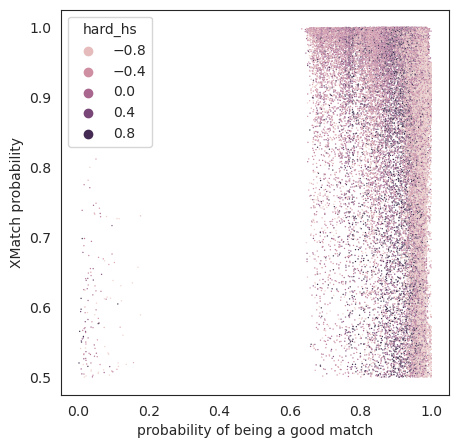

In [170]:
sns.scatterplot(x=y_pred_totest, y=df_to_test['match_probability'], hue=df_to_test['hard_hs'], s=1);
plt.xlabel('probability of being a good match')
plt.ylabel('XMatch probability')

In [146]:
yangetal = pd.read_csv('data/CXO Training Dataset.csv', index_col=False)
df_to_test['probs_pred'] = y_pred_totest
yangxtest = pd.merge(df_to_test, yangetal, on='name')

In [152]:
yangxtest.shape

(1322, 218)

In [147]:
# Group the data by 'Class' and calculate the mean probability and count for each group
grouped_df = yangxtest.groupby('Class').agg({
    'probs_pred': ['mean'],
    'Class': ['count']
}).reset_index()

# Calculate the total number of rows for percentage calculation
total_rows = len(yangxtest)

# Add a new column to store the percentage of each class
grouped_df['percentage'] = (grouped_df[('Class', 'count')] / total_rows) * 100

# Rename columns for easier interpretation
grouped_df.columns = ['Class', 'Mean Probability', 'Count', 'Percentage']

print(grouped_df)


     Class  Mean Probability  Count  Percentage
0      AGN          0.421629    605   45.763994
1       CV          0.558383     20    1.512859
2  HM-STAR          0.864069     61    4.614221
3     HMXB          0.447407     11    0.832073
4  LM-STAR          0.915204    388   29.349470
5     LMXB          0.480491     17    1.285930
6       NS          0.861158      1    0.075643
7      YSO          0.776809    219   16.565809


In [148]:
# Filter DataFrame based on 'probs_pred' > 0.5
filtered_gt_05 = yangxtest[yangxtest['probs_pred'] > 0.5]

# Filter DataFrame based on 'probs_pred' <= 0.5
filtered_le_05 = yangxtest[yangxtest['probs_pred'] <= 0.5]

# Group by 'Class' and count for probs > 0.5
grouped_gt_05 = filtered_gt_05['Class'].value_counts().reset_index()
grouped_gt_05.columns = ['Class', 'Count_gt_05']
grouped_gt_05['Percentage_gt_05'] = (grouped_gt_05['Count_gt_05'] / grouped_gt_05['Count_gt_05'].sum()) * 100

# Group by 'Class' and count for probs <= 0.5
grouped_le_05 = filtered_le_05['Class'].value_counts().reset_index()
grouped_le_05.columns = ['Class', 'Count_le_05']
grouped_le_05['Percentage_le_05'] = (grouped_le_05['Count_le_05'] / grouped_le_05['Count_le_05'].sum()) * 100


In [149]:
grouped_gt_05

,Class,Count_gt_05,Percentage_gt_05
0,LM-STAR,383,44.483159
1,AGN,200,23.228804
2,YSO,195,22.648084
3,HM-STAR,57,6.620209
4,CV,12,1.393728
5,LMXB,9,1.045296
6,HMXB,4,0.464576
7,NS,1,0.116144


In [150]:
grouped_le_05

,Class,Count_le_05,Percentage_le_05
0,AGN,405,87.852495
1,YSO,24,5.206074
2,CV,8,1.735358
3,LMXB,8,1.735358
4,HMXB,7,1.518438
5,LM-STAR,5,1.084599
6,HM-STAR,4,0.867679


<Axes: ylabel='match_probability'>

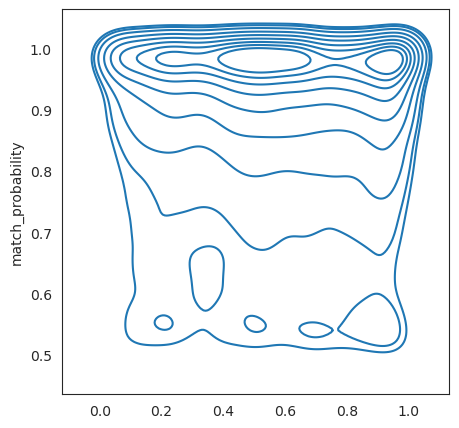

In [69]:
sns.kdeplot(x=y_pred_totest, y=df_to_test['match_probability'])


Text(0, 0.5, 'separation')

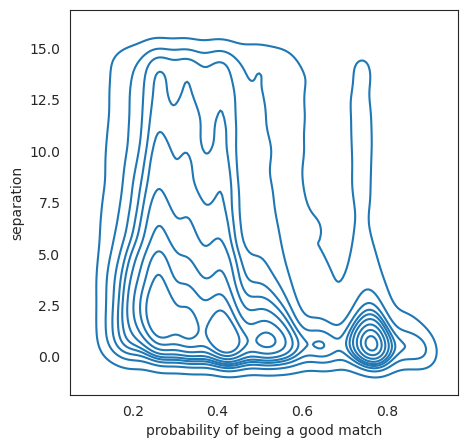

In [66]:
sns.kdeplot(x=y_pred_totest, y=df_to_test['angDist'])
plt.xlabel('probability of being a good match')
plt.ylabel('separation')

Text(0, 0.5, 'separation')

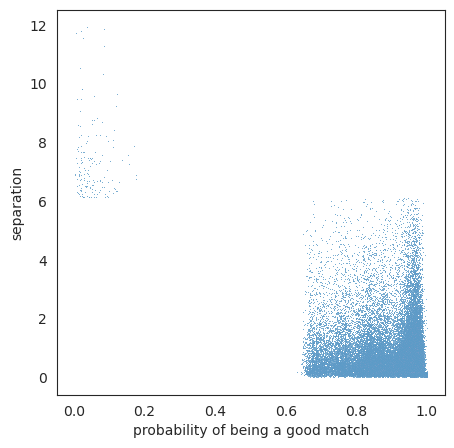

In [171]:
sns.scatterplot(x=y_pred_totest, y=df_to_test['separation'], s=0.5);
plt.xlabel('probability of being a good match')
plt.ylabel('separation')